In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
!nvidia-smi

Fri Jun  3 02:37:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
size = (256, 256)

In [ ]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = self.transform(mask)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = sorted(glob.glob('/content/drive/MyDrive/satellite/images/*.jpg'))
y = sorted(glob.glob('/content/drive/MyDrive/satellite/masks/*.jpg'))

In [ ]:
len(X)

2841

In [ ]:
len(y)

2841

In [ ]:
train_X = X[:2800]
train_y = y[:2800]

In [ ]:
valid_X = X[2800:]
valid_y = y[2800:]

In [ ]:
train_dataset = LoadData(train_X, train_y)
valid_dataset = LoadData(valid_X, valid_y)

In [ ]:
img, mask = train_dataset[0]

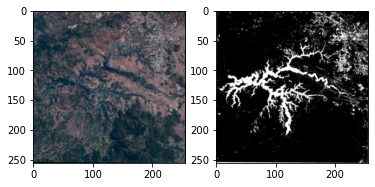

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [ ]:
img.shape

torch.Size([3, 256, 256])

In [ ]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [ ]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [ ]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = self.output(d4)
        output_mask = torch.sigmoid(output_mask)

        return output_mask

In [ ]:
batch_size = 8
num_epochs = 12
lr = 1e-4
checkpoint_path = "./checkpoint.pth"

In [ ]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

In [ ]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        dice_loss = 1 - dice_score
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

In [ ]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
train = []
valid = []

best_valid_loss = float("inf")

for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train.append(train_loss)
        valid.append(valid_loss)

        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        data_str = f'Epoch: {epoch+1:02}\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

Valid loss improved from inf to 0.6455. Saving checkpoint: ./checkpoint.pth
Epoch: 01
	Train Loss: 0.843
	 Val. Loss: 0.645

Valid loss improved from 0.6455 to 0.5781. Saving checkpoint: ./checkpoint.pth
Epoch: 02
	Train Loss: 0.732
	 Val. Loss: 0.578

Epoch: 03
	Train Loss: 0.659
	 Val. Loss: 0.595

Valid loss improved from 0.5781 to 0.5382. Saving checkpoint: ./checkpoint.pth
Epoch: 04
	Train Loss: 0.605
	 Val. Loss: 0.538

Valid loss improved from 0.5382 to 0.5331. Saving checkpoint: ./checkpoint.pth
Epoch: 05
	Train Loss: 0.573
	 Val. Loss: 0.533

Valid loss improved from 0.5331 to 0.5278. Saving checkpoint: ./checkpoint.pth
Epoch: 06
	Train Loss: 0.556
	 Val. Loss: 0.528

Valid loss improved from 0.5278 to 0.5050. Saving checkpoint: ./checkpoint.pth
Epoch: 07
	Train Loss: 0.533
	 Val. Loss: 0.505

Valid loss improved from 0.5050 to 0.5017. Saving checkpoint: ./checkpoint.pth
Epoch: 08
	Train Loss: 0.520
	 Val. Loss: 0.502

Valid loss improved from 0.5017 to 0.4902. Saving checkpoi

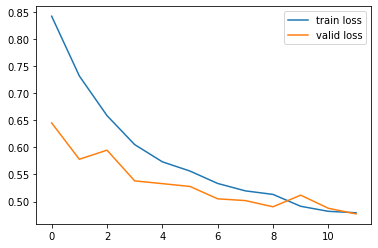

In [ ]:
plt.plot(range(0,12), train, label='train loss')
plt.plot(range(0,12), valid, label='valid loss')
plt.legend()

In [ ]:
m = UNet()
m.load_state_dict(torch.load(checkpoint_path))
m = m.to(device)

torch.Size([3, 256, 256])
(8, 1, 256, 256)


<Figure size 2160x576 with 0 Axes>

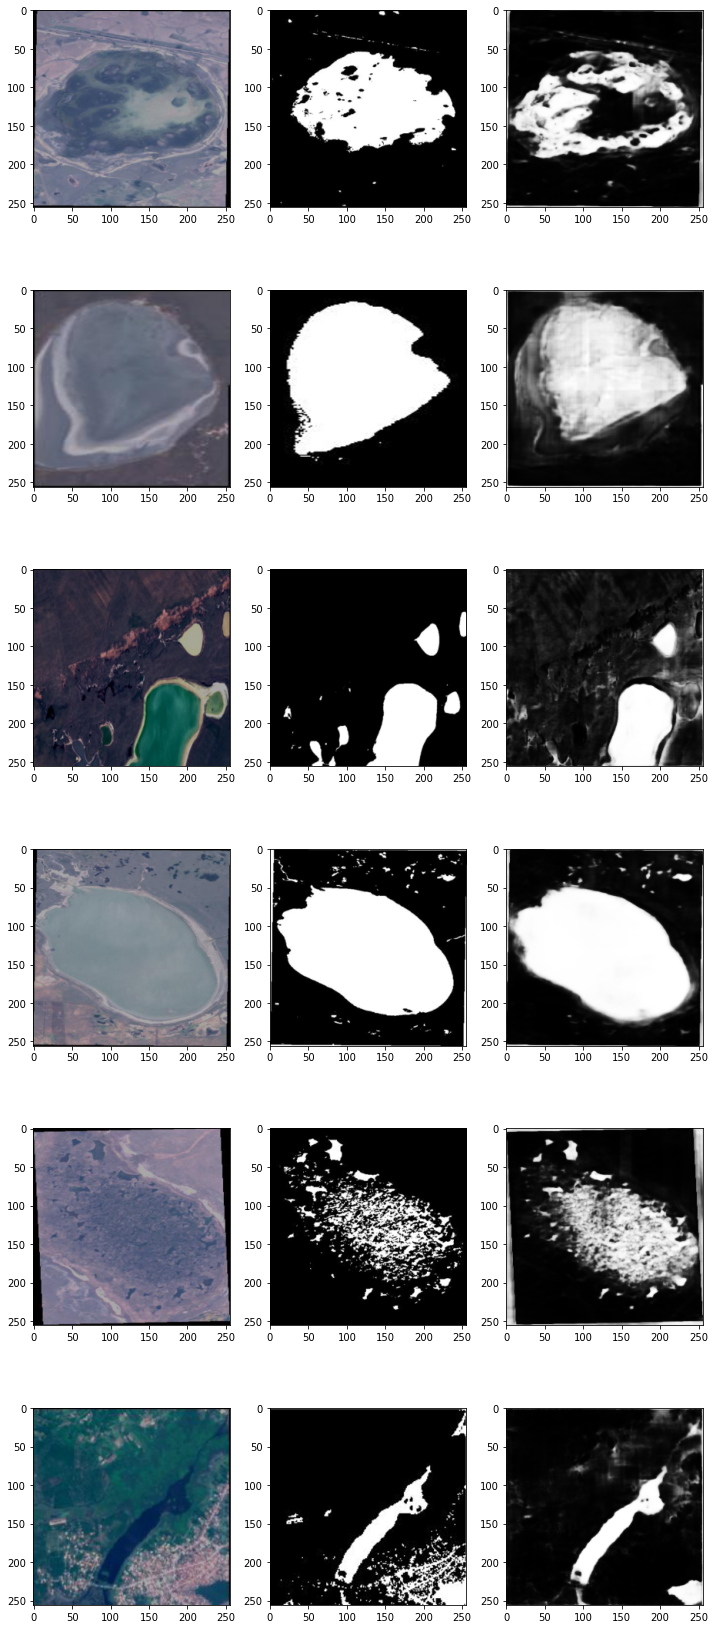

In [ ]:
transform = transforms.ToPILImage()
pred = []
for x, y in valid_loader:
    image0 = transform(x[0])
    image1 = transform(x[1])
    image2 = transform(x[2])
    image3 = transform(x[3])
    image4 = transform(x[4])
    image5 = transform(x[5])
    print(x[0].shape)
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    y_pred = m(x)
    img = y_pred.cpu().detach().numpy()
    plt.figure(figsize=(30,8))
    print(img.shape)
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(6,3)
    f.set_size_inches(12, 30, forward=True)
    axarr[0,0].imshow(image0)
    axarr[0,1].imshow(np.squeeze(y.cpu().detach().numpy())[0], cmap='gray')
    axarr[0,2].imshow(np.squeeze(img)[0], cmap='gray')

    axarr[1,0].imshow(image1)
    axarr[1,1].imshow(np.squeeze(y.cpu().detach().numpy())[1], cmap='gray')
    axarr[1,2].imshow(np.squeeze(img)[1], cmap='gray')

    axarr[5,0].imshow(image2)
    axarr[5,1].imshow(np.squeeze(y.cpu().detach().numpy())[2], cmap='gray')
    axarr[5,2].imshow(np.squeeze(img)[2], cmap='gray')

    axarr[2,0].imshow(image3)
    axarr[2,1].imshow(np.squeeze(y.cpu().detach().numpy())[3], cmap='gray')
    axarr[2,2].imshow(np.squeeze(img)[3], cmap='gray')

    axarr[3,0].imshow(image4)
    axarr[3,1].imshow(np.squeeze(y.cpu().detach().numpy())[4], cmap='gray')
    axarr[3,2].imshow(np.squeeze(img)[4], cmap='gray')

    axarr[4,0].imshow(image5)
    axarr[4,1].imshow(np.squeeze(y.cpu().detach().numpy())[5], cmap='gray')
    axarr[4,2].imshow(np.squeeze(img)[5], cmap='gray')
    break

In [ ]:
dice_BCE = evaluate(m, valid_loader, loss_fn, device)

In [ ]:
dice_BCE

0.4773574968179067

In [ ]:
def dice_score(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

            y_pred = model(x)
            inputs = y_pred.view(-1)
            targets = y.view(-1)
            smooth = 1

            intersection = (inputs * targets).sum()
            dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
            epoch_loss += dice_score

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [ ]:
diceScore = dice_score(m, valid_loader, loss_fn, device)

In [ ]:
diceScore.item()

0.8098794221878052

In [ ]:
class LoadPredictionData(Dataset):
    def __init__(self, images_path):
        super().__init__()

        self.images_path = images_path
        # self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        # mask = Image.open(self.masks_path[idx]).convert('L')
        # mask = self.transform(mask)
        # mask = np.expand_dims(mask, axis=0)
        # mask = mask/255.0
        # mask = torch.tensor(mask)

        return img

    def __len__(self):
        return self.len

In [ ]:
pred_img = sorted(glob.glob('/content/drive/MyDrive/satellite/download.jpg'))

In [ ]:
pred_dataset = LoadPredictionData(pred_img)

In [ ]:
len(pred_dataset)

0

In [ ]:
prediction_loader = DataLoader(
        dataset=pred_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

In [ ]:
transform = transforms.ToPILImage()
pred = []
for x in prediction_loader:
    image0 = transform(x[0])

    print(x[0].shape)
    x = x.to(device, dtype=torch.float32)
    # y = y.to(device, dtype=torch.float32)

    y_pred = m(x)
    img = y_pred.cpu().detach().numpy()
    plt.figure(figsize=(30,8))
    print(img.shape)
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(6,3)
    f.set_size_inches(12, 30, forward=True)
    axarr[0,0].imshow(image0)
    # axarr[0,1].imshow(np.squeeze(y.cpu().detach().numpy())[0], cmap='gray')
    axarr[0,2].imshow(img[0,0,:,:], cmap='gray')

    # axarr[1,0].imshow(image1)
    # axarr[1,1].imshow(np.squeeze(y.cpu().detach().numpy())[1], cmap='gray')
    # axarr[1,2].imshow(np.squeeze(img)[1], cmap='gray')

    # axarr[5,0].imshow(image2)
    # axarr[5,1].imshow(np.squeeze(y.cpu().detach().numpy())[2], cmap='gray')
    # axarr[5,2].imshow(np.squeeze(img)[2], cmap='gray')

    # axarr[2,0].imshow(image3)
    # axarr[2,1].imshow(np.squeeze(y.cpu().detach().numpy())[3], cmap='gray')
    # axarr[2,2].imshow(np.squeeze(img)[3], cmap='gray')

    # axarr[3,0].imshow(image4)
    # axarr[3,1].imshow(np.squeeze(y.cpu().detach().numpy())[4], cmap='gray')
    # axarr[3,2].imshow(np.squeeze(img)[4], cmap='gray')

    # axarr[4,0].imshow(image5)
    # axarr[4,1].imshow(np.squeeze(y.cpu().detach().numpy())[5], cmap='gray')
    # axarr[4,2].imshow(np.squeeze(img)[5], cmap='gray')
    break

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 8.0 MB/s 
     |████████████████████████████████| 2.0 MB 53.0 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 256 kB 68.0 MB/s 
     |████████████████████████████████| 212 kB 67.8 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 56.5 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 59.2 MB/s 
     |████████████████████████████████| 11.1 MB 47.7 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 10.8 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 856 

In [ ]:
def segment(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  cv2.imwrite('/content/drive/MyDrive/satellite/test.jpg',image)
  pred_img = sorted(glob.glob('/content/drive/MyDrive/satellite/test.jpg'))
  print(image.shape)
  pred_dt = LoadPredictionData(pred_img)
  print(len(pred_dt))
  prediction_lr = DataLoader(dataset=pred_dt, batch_size=batch_size, shuffle=False, num_workers=2,)
  print(len(prediction_lr))
  for x in prediction_lr:
    print("####################")
    print(x[0].shape)
    image0 = transform(x[0])
    print("####################")
    x = x.to(device, dtype=torch.float32)
    print("####################")
    y_pred = m(x)
    print("####################")
    img = y_pred.cpu().detach().numpy()
    break
  print("**********************************************")
  return img[0,0,:,:]
  # return

In [ ]:
# ans=segment(pred_img)
# print(ans.shape)
# plt.figure(figsize=(9,9))
# plt.subplot(1,1,1)
# plt.imshow(ans,cmap='gray')

In [ ]:
import numpy as np

import gradio as gr
image = gr.inputs.Image(shape = (256, 256),type="numpy")
demo = gr.Interface(fn=segment, inputs=image, outputs="image")
demo.launch(auth=('user','password'),debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://50712.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
(256, 256, 3)
1
1
####################
torch.Size([3, 256, 256])
####################
####################
####################
**********************************************
(256, 256, 3)
1
1
####################
torch.Size([3, 256, 256])
####################
####################
####################
**********************************************
(256, 256, 3)
1
1
####################
torch.Size([3, 256, 256])
####################
####################
####################
**********************************************
(256, 256, 3)
1
1
####################
torch.Size([3, 256, 256])
####################
####################
####################
**********************************************
K

(<gradio.routes.App at 0x7f2ee3ecd410>,
 'http://127.0.0.1:7860/',
 'https://50712.gradio.app')